In [11]:
import sys
import os
import numpy as np
import h5py
import scipy.io
import tensorflow as tf
from keras import ops
import keras
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import concatenate
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
import keras_tuner as kt

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import math

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, f1_score
import sys
sys.path.append("/hpcnfs/data/GN2/gmandana/take2project/clip_2_electric_boogaloo/analysis/NN/Neural_Network_DNA_Demo")
sys.path.append("/hpcnfs/data/GN2/gmandana/bin/DeepRiPe_edited/Scripts/")
from helper import IOHelper, SequenceHelper

import random
#rs = 1234
rs = 2341234123
random.seed(rs)

In [12]:
### I'm redefining the function from igrads to use a different font
import pandas as pd
import logomaker
def plot_sequence_attribution(attribution_matrix, sigma=['A', 'C', 'G', 'T'], width=20, height=4):
    attribution_df = pd.DataFrame(attribution_matrix, columns=sigma)

    # create Logo object
    attribution_logo = logomaker.Logo(attribution_df,
                            shade_below=.5,
                            fade_below=.5,
                            font_name='DejaVu Sans')

    # style using Logo methods
    attribution_logo.style_spines(visible=False)
    attribution_logo.style_spines(spines=['left', 'bottom'], visible=True)
    #attribution_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

    # style using Axes methods
    attribution_logo.ax.set_ylabel("IG Attribution", labelpad=-1)
    #attribution_logo.ax.xaxis.set_tick_params(which='both', bottom=False, top=False, labelbottom=False)

    # adjust figure width and heigh
    attribution_logo.fig.set_figheight(height)
    attribution_logo.fig.set_figwidth(width)

    return attribution_logo

In [14]:
ntask = 1

### read in the sequence data
model_path = "/hpcnfs/data/GN2/gmandana/bin/restr_NN/"
fg_fasta_data = IOHelper.get_fastas_from_file("/hpcnfs/data/GN2/gmandana/bin/4.1.0/home/ieo5559/unifiedCLIP/NN_files/siW/fg_v6.fa", uppercase=True)
bg_fasta_data = IOHelper.get_fastas_from_file("/hpcnfs/data/GN2/gmandana/bin/4.1.0/home/ieo5559/unifiedCLIP/NN_files/siW/bg_v6.fa", uppercase=True)

sequence_length = len(fg_fasta_data.sequence[0])

fg_seq_matrix = SequenceHelper.do_one_hot_encoding(fg_fasta_data.sequence, sequence_length, SequenceHelper.parse_alpha_to_seq)
bg_seq_matrix = SequenceHelper.do_one_hot_encoding(bg_fasta_data.sequence, sequence_length, SequenceHelper.parse_alpha_to_seq)

seq_matrix = np.concatenate((fg_seq_matrix ,bg_seq_matrix))

In [15]:
### generate labels
Y = np.hstack([np.ones((np.shape(fg_seq_matrix)[0], )), np.zeros((np.shape(bg_seq_matrix)[0], ))])
#Y = np.hstack([np.zeros((np.shape(fg_seq_matrix)[0], )), np.ones((np.shape(bg_seq_matrix)[0], ))])

X_train, X_test, y_train , y_test = train_test_split(seq_matrix, Y, test_size = 0.3, random_state = rs)

## Model performance

In [17]:
model_path = "/hpcnfs/data/GN2/gmandana/bin/restr_NN/"
#model=load_model(os.path.join(model_path, "siW_NN_v5.keras"), custom_objects={"custom_fn": myprecision, "custom_fn": myrecall})
model=load_model(os.path.join(model_path, "siW_NN_v5.keras"))
from igrads import integrated_gradients
np.set_printoptions(suppress=True)
inp_dim_1 = 500
pred = model.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [18]:
preds_cat = [ 0 if i < 0.5 else 1 for i in pred ]

In [19]:
#model performance
np.unique(preds_cat == y_test, return_counts=True)

f1_score(y_test, preds_cat)

#area under ROC AUC curve
roc_auc_score(y_test, preds_cat)

0.8569015702831583

In [20]:
indices = range(0,5)
print(y_test[indices])
model.predict(X_test[indices].reshape(5,inp_dim_1,4))
#model.predict(np.zeros((1,500,4)))

[1. 0. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.9997588 ],
       [0.00265309],
       [0.29594135],
       [0.94419146],
       [0.8017935 ]], dtype=float32)

## visualise attributions

In [21]:
ind = 1

print(model.predict(X_test[ind].reshape(1,inp_dim_1,4)))
# baseline of zeros
baseline = np.full((inp_dim_1,4), 0.0)
attriutions = integrated_gradients(X_test[ind], baseline, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.00265309]]


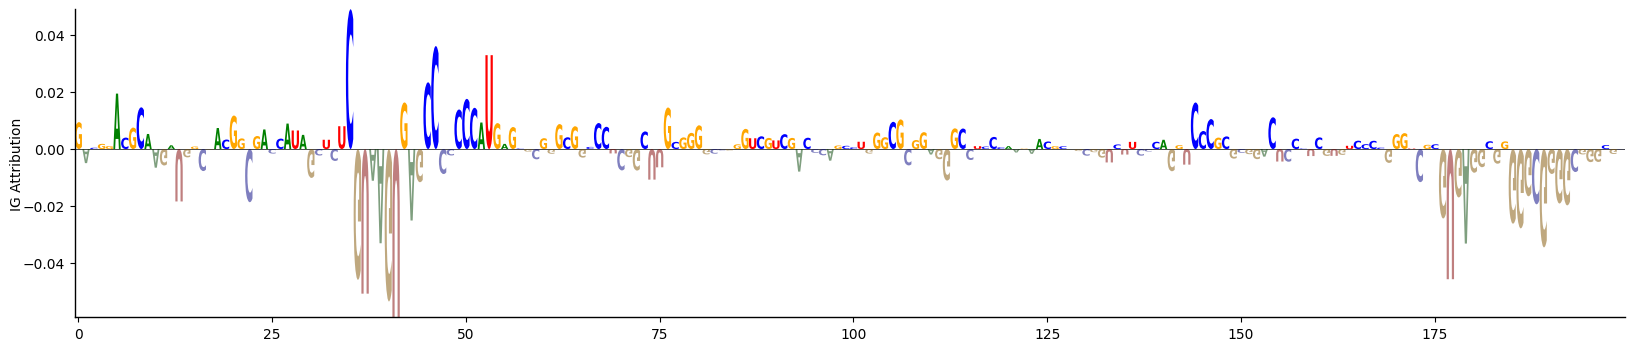

In [23]:
%matplotlib inline
plot_sequence_attribution(attriutions.numpy()[100:300], sigma=['A', 'C', 'U', 'G'])
#plot_sequence_attribution(attriutions.numpy()[400:600,:], sigma=['A', 'C', 'U', 'G'])